# Evaluating the Adaptive Grid (AG) Coordinate

This notebook evaluates the performance of the AG coordinate using a single density slice snapshot from the ANU-tub configuration. The AG coordinate is calculated using Angus' `pyale` package (see `AG_VertRegrid.py` for implementation) to preprocess the coordinate remapping as a function of parameter choices, and compares this with other coordinates and our expectations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cm

## 1. Default Case
The plot below shows a default mapping of the AG coordinate. The input is on a z* grid, meaning we integrate the coordinate forward in time for 200 iterations of a 3600 second timestep.

In [2]:
def tpplot(field,vlev=50,cmap=cm.cm.thermal):
    depth=field.depth.values
    temp=field.temp
    yh=field.yh.values
    plt.figure(figsize=(12,6))
    plt.subplot(211)
    p1 = temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cmap)
    for ii in range(75):
        if np.mod(ii,10)==5:
            plt.plot(yh,depth[ii,:],'m',linewidth=0.6)
        else:
            plt.plot(yh,depth[ii,:],'w',linewidth=0.3)
    plt.ylim([0,500])
    plt.gca().invert_yaxis()
    
    plt.subplot(212)
    p1 = temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cmap)
    for ii in range(75):
        if np.mod(ii,10)==5:
            plt.plot(yh,depth[ii,:],'m',linewidth=0.6)
        else:
            plt.plot(yh,depth[ii,:],'w',linewidth=0.3)
    plt.ylim([500,4000])
    plt.gca().invert_yaxis()
    
    plt.subplots_adjust(hspace=0)

    ax_c = plt.axes([0.92,0.3,0.01,0.4])
    plt.colorbar(p1,ax_c)

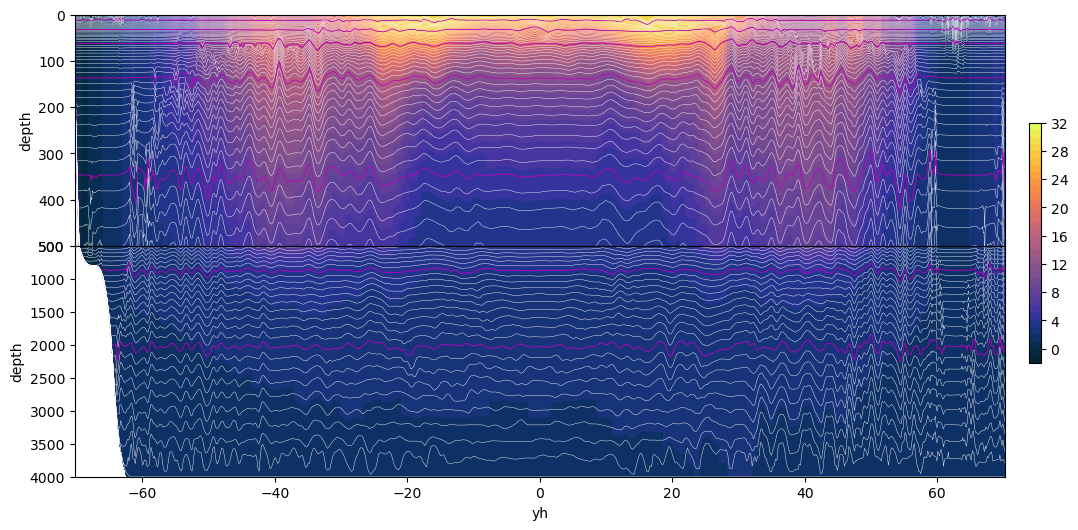

In [12]:
vlev = np.linspace(-2,32,35)
temp_depth = xr.open_dataset('x77/anu-tub/diagnostics/OUTPUTS/vary_iter/temp_iter_200.nc')
tpplot(temp_depth,vlev=vlev,cmap=cm.cm.thermal)

This plot shows how the coordinate responds to align interfaces with small-scale fluctuations (eddies) but that it doesn't along with density surfaces on large scales.

## 2. Numerical implementation
We first test out the input parameters used by the `pyale` software.

### 2.1 Dependence on iterations

To fully evaluate the performance of the coordinate we need to know whether we have done a sufficient number of iterations to converge on a solution. For this test we vary iteration number from 2 to 2000, and look at **just a small portion of the domain** to test how well the coordinate converges.

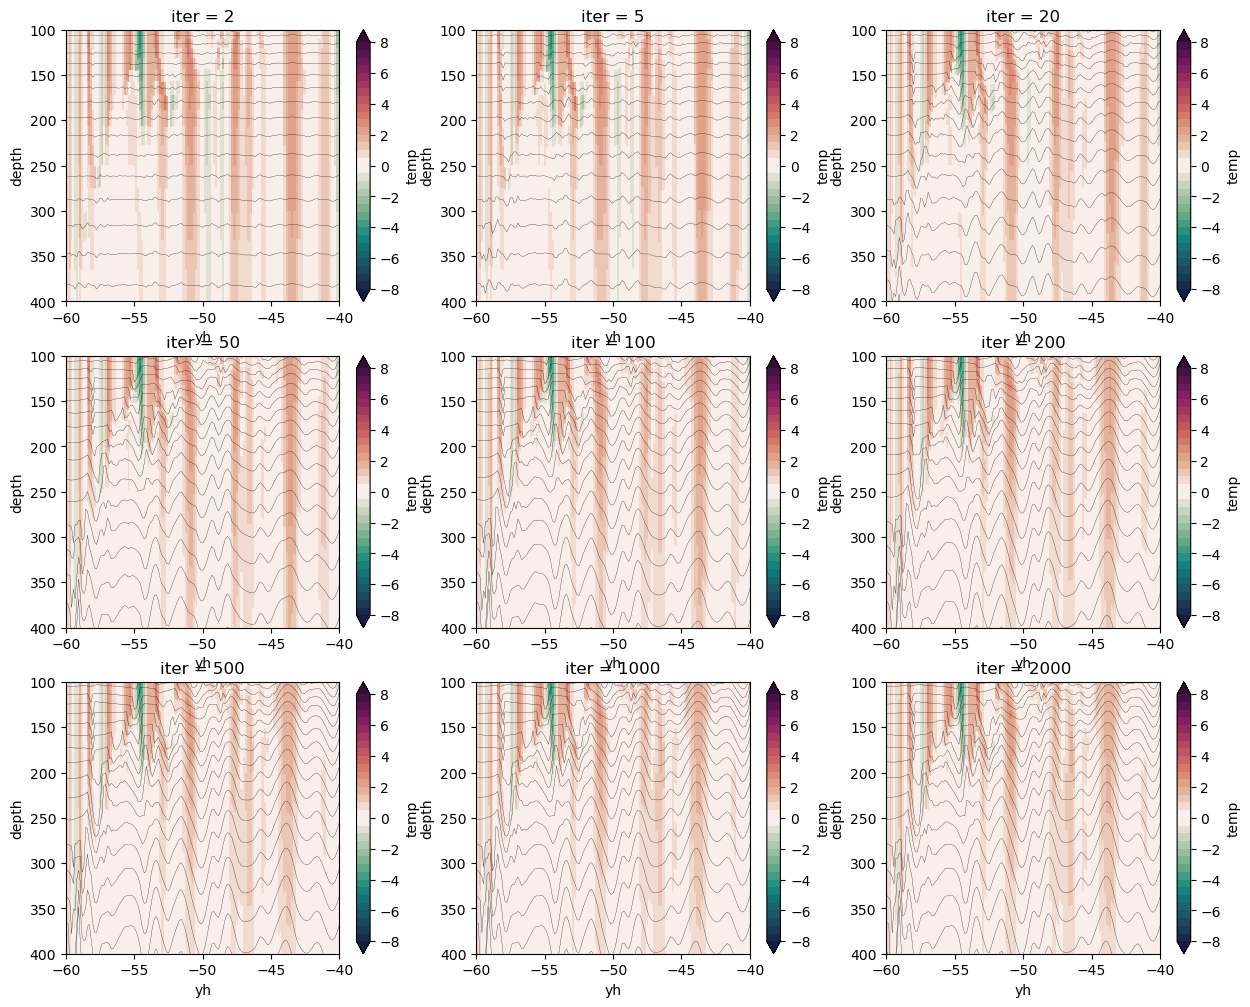

In [68]:
plt.figure(figsize=(15,12))
vlev = np.linspace(-8,8,33)
jj=0
for iter in [2, 5, 20, 50, 100, 200, 500, 1000, 2000]: # Also did 10
    jj+=1
    temp_depth = xr.open_dataset('x77/anu-tub/diagnostics/OUTPUTS/vary_iter/temp_iter_'+str(iter)+'.nc')
    delT = temp_depth.temp.differentiate('yh')
    depth=temp_depth.depth.values
    yh=temp_depth.yh.values
    plt.subplot(3,3,jj)
    delT.plot(y = "depth",levels=vlev,cmap=cm.cm.curl)
    for ii in range(75):
        plt.plot(yh,depth[ii,:],'k',linewidth=0.2)
    plt.ylim([100,400])
    plt.gca().invert_yaxis()
    plt.xlim([-60,-40])
    plt.title('iter = '+str(iter))


**This plot shows** along-layer temperature gradient for just a small section close to the surface of the Southern Ocean. The top left region has very weak stratification and so the AG coordinate flattens out and temperature gradients are large. Regions with stronger stratification converge towards a state with reduced along-coordinate temperature gradients, and larger deviations of the coordinate interface.

The convergence of coordinate with number of iterations can be measured by the average of the absolute value of the temperature gradient in regions with strong stratification (50S to 50N, beneath 200m):

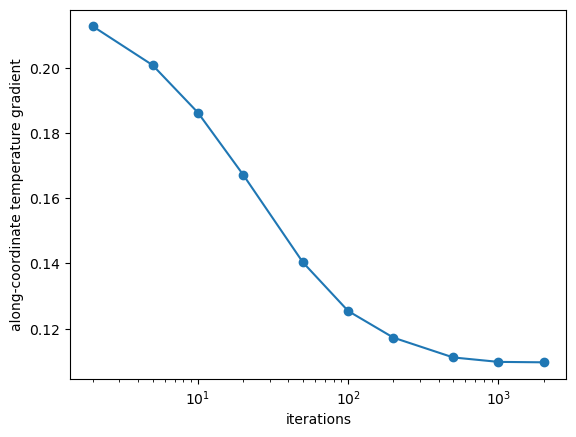

In [62]:
delTmean = []
iters = [2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
for iter in iters: 
    temp_depth = xr.open_dataset('x77/anu-tub/diagnostics/OUTPUTS/vary_iter/temp_iter_'+str(iter)+'.nc')
    delT1 = np.fabs(temp_depth.temp.differentiate('yh').sel(yh=slice(-50,50)).isel(zl=slice(39,70))).mean().values.item()
    delTmean.append(delT1)
    
plt.semilogx(iters,delTmean,'-o')
plt.xlabel('iterations')
plt.ylabel('along-coordinate temperature gradient');

**This plot** suggests that around 200-500 iterations is sufficiently close to a converged solution.

### 2.2 Effect of timestep
One further question is whether we can accelerate the process by taking longer timesteps:

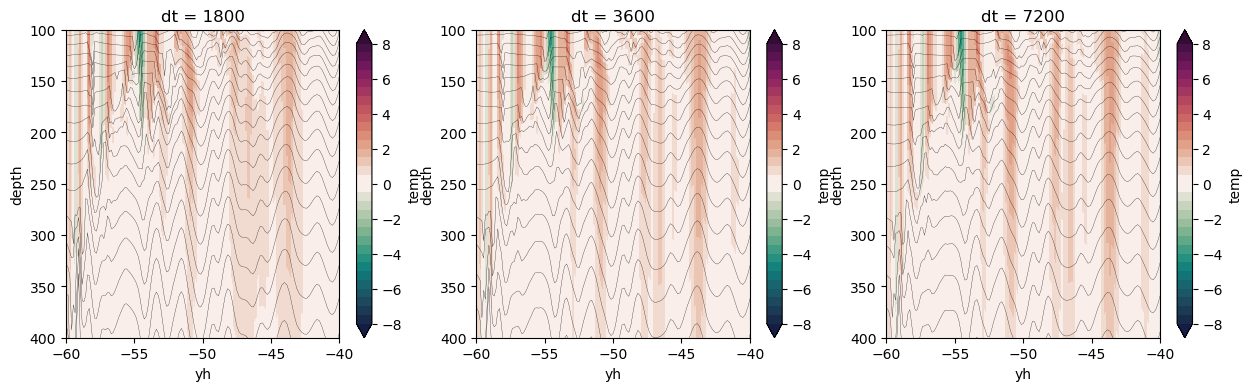

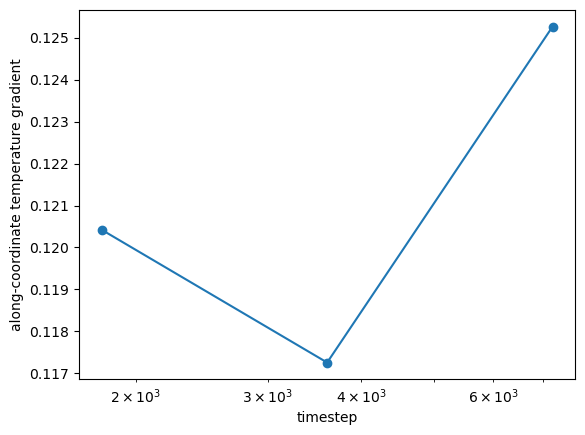

In [8]:
plt.figure(figsize=(15,4))
vlev = np.linspace(-8,8,33)
delTmean = []
jj=0
dts=[1800, 3600, 7200]
for dt in dts: 
    jj+=1
    temp_depth = xr.open_dataset('x77/anu-tub/diagnostics/OUTPUTS/vary_dt/temp_dt_'+str(dt)+'.nc')
    delT = temp_depth.temp.differentiate('yh')
    depth=temp_depth.depth.values
    yh=temp_depth.yh.values
    plt.subplot(1,3,jj)
    delT.plot(y = "depth",levels=vlev,cmap=cm.cm.curl)
    for ii in range(75):
        plt.plot(yh,depth[ii,:],'k',linewidth=0.2)
    plt.ylim([100,400])
    plt.gca().invert_yaxis()
    plt.xlim([-60,-40])
    plt.title('dt = '+str(dt))
    
    delT1 = np.fabs(temp_depth.temp.differentiate('yh').sel(yh=slice(-50,50)).isel(zl=slice(39,70))).mean().values.item()
    delTmean.append(delT1)

plt.figure()
plt.semilogx(dts,delTmean,'-o')
plt.xlabel('timestep')
plt.ylabel('along-coordinate temperature gradient');

**Therefore** we suspect that the timestep parameter in `pyale` doesn't do much to affect the evolution of the coordinate, and will leave it at 3600 for future tests.

## 3. AG Parameter dependence
The AG routines within MOM6 solve for the evolution of the interface heights as per

$
\partial_t z_k = -\nabla_H \cdot \biggl(%
\underbrace{\vphantom{Biggl(\Biggr)}\omega_\sigma \frac{\kappa \nabla_H\sigma}{\sqrt{(\partial_z\sigma)^2 + \left(\nabla_H\sigma\right)^2}}}_\text{density adaptivity} + %
\underbrace{\vphantom{\Biggl(\Biggr)}
  \omega_z \kappa\nabla_H z_k}_{\substack{\text{lateral}\\\text{smoothing}}}\biggr) + %
\underbrace{\vphantom{\Biggl(\Biggr)}\tau_r^{-1} \left(z_k^* - z_k\right)}_\text{vertical restoring} + %
\underbrace{\vphantom{\Biggl(\Biggr)}F_\text{con}}_{\quad\substack{\text{convective}\\\text{adjustment}}},
$

where $z_k$ is the height of the interface $k$ (between layers $k$ and $k+1$;
$\nabla_H$ is the gradient operator acting along coordinate surfaces; $\sigma$
is the locally-referenced potential density; $\omega_\sigma$ is a weighting
towards density adaptivity; $\kappa$ is a lateral diffusivity that is constant
within a given vertical column; $\omega_z$ is a weighting towards lateral
smoothing (typically $1-\omega_\sigma$); $\tau_r$ is a timescale of restoring
toward a nominal coordinate; $z_k^*$ is the nominal coordinate used for
restoring; and $F_\text{con}$ is the source term corresponding to the grid
adjustment routine.

We now proceed to test the effect of each of the parameters controlling the evolution of the interface.

### 3.1 Restoring timescale
First, we vary $\tau_r$, which is expressed in the code as the parameter `ADAPT_RESTORING_TIMESCALE`. We vary this parameter from 1 day (rapid restoring) to 100 days.

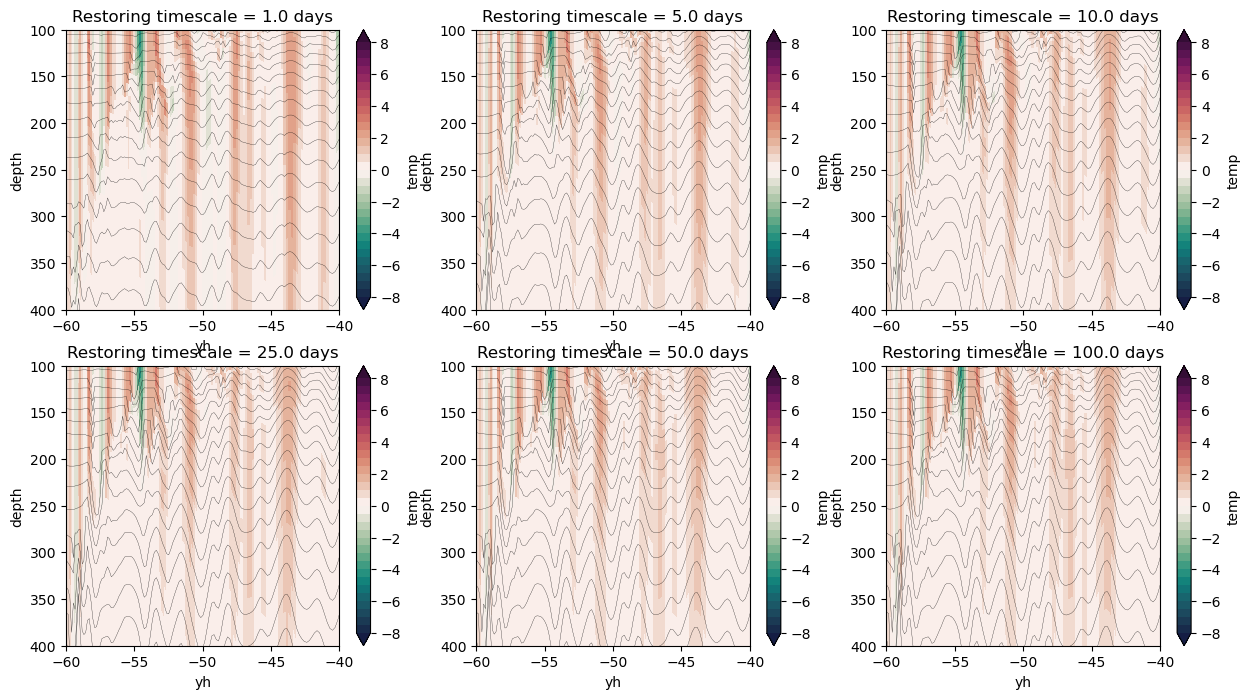

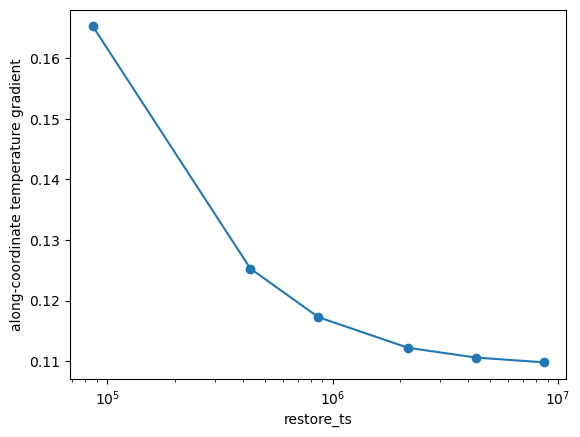

In [17]:
plt.figure(figsize=(15,8))
vlev = np.linspace(-8,8,33)
delTmean = []
jj=0
restore_ts=[86400.0, 432000.0, 864000.0, 2160000.0, 4320000.0, 8640000.0]
for restore in restore_ts: 
    jj+=1
    temp_depth = xr.open_dataset('x77/anu-tub/diagnostics/OUTPUTS/vary_restore_ts/temp_restore_ts_'+str(restore)+'.nc')
    delT = temp_depth.temp.differentiate('yh')
    depth=temp_depth.depth.values
    yh=temp_depth.yh.values
    plt.subplot(2,3,jj)
    delT.plot(y = "depth",levels=vlev,cmap=cm.cm.curl)
    for ii in range(75):
        plt.plot(yh,depth[ii,:],'k',linewidth=0.2)
    plt.ylim([100,400])
    plt.gca().invert_yaxis()
    plt.xlim([-60,-40])
    plt.title('Restoring timescale = '+str(restore/86400)+' days')
    
    delT1 = np.fabs(temp_depth.temp.differentiate('yh').sel(yh=slice(-50,50)).isel(zl=slice(39,70))).mean().values.item()
    delTmean.append(delT1)

plt.figure()
plt.semilogx(restore_ts,delTmean,'-o')
plt.xlabel('restore_ts (sec)')
plt.ylabel('along-coordinate temperature gradient');

This analysis suggests that a longer timescale than the default (10 day) timescale may give allow for a better alignment with density surfaces, without compromising the mean layer thicknesses. We suggest 50 days as a suitable timescale.

**However,** it's notable that none of these parameters generate a coordinate that "sees" the large-scale shape of the stratication; instead, it is the mesoscale variability that dominates the shape of the coordinate.

### Smoothing

Next we vary the rate of smoothing of interface heights:

`ADAPT_SMOOTH_MIN = 0.1          !   [not defined] default = 0.0; Minimum weight toward smoothing term`

The issue here is that, in the region close to where the density adaptivity switches off, we get some pretty sharp interfaces. In the absence of another mechanism to to control this issue by increasing the rate of smoothing.

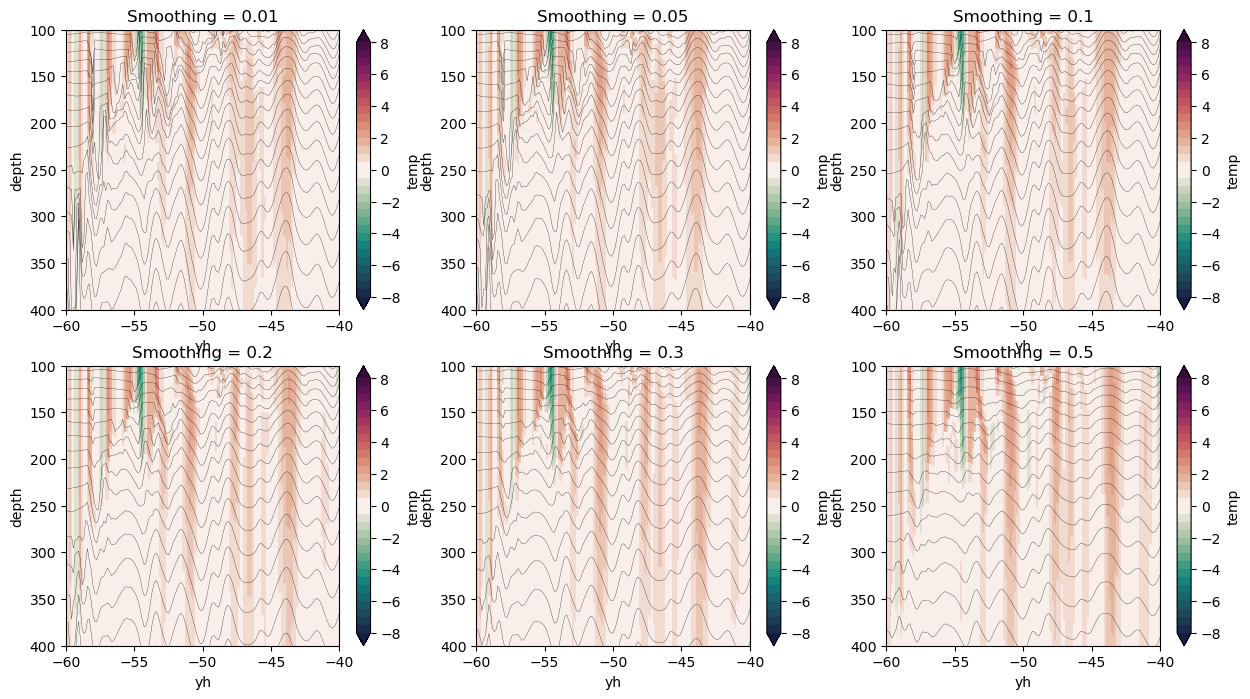

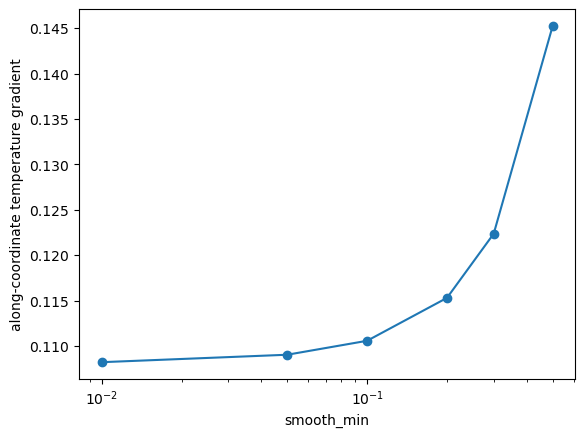

In [17]:
plt.figure(figsize=(15,8))
vlev = np.linspace(-8,8,33)
delTmean = []
jj=0
smooth_mins=[0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
for smooth_min in smooth_mins: 
    jj+=1
    temp_depth = xr.open_dataset('x77/anu-tub/diagnostics/OUTPUTS/vary_smooth_min/temp_smooth_min_'+str(smooth_min)+'.nc')
    delT = temp_depth.temp.differentiate('yh')
    depth=temp_depth.depth.values
    yh=temp_depth.yh.values
    plt.subplot(2,3,jj)
    delT.plot(y = "depth",levels=vlev,cmap=cm.cm.curl)
    for ii in range(75):
        plt.plot(yh,depth[ii,:],'k',linewidth=0.2)
    plt.ylim([100,400])
    plt.gca().invert_yaxis()
    plt.xlim([-60,-40])
    plt.title('Smoothing = '+str(smooth_min))
    
    delT1 = np.fabs(temp_depth.temp.differentiate('yh').sel(yh=slice(-50,50)).isel(zl=slice(39,70))).mean().values.item()
    delTmean.append(delT1)

plt.figure()
plt.semilogx(smooth_mins,delTmean,'-o')
plt.xlabel('smooth_min')
plt.ylabel('along-coordinate temperature gradient');

In this example, increasing smoothing to a rate of 0.2 seems to give a better result without really compromising along-layer gradients.

### Slope cutoff

The scheme has a sudden switch between stratified and unstratified regions. When the region is deemed to be unstratified, the densitivity adaptivity is switched off and the coordinate is ccloser to geopotential.

`ADAPT_SLOPE_CUTOFF = 0.01       !   [not defined] default = 0.01; Slope cutoff between stratified and unstratified regions`

We've tried a few different values of this parameter.

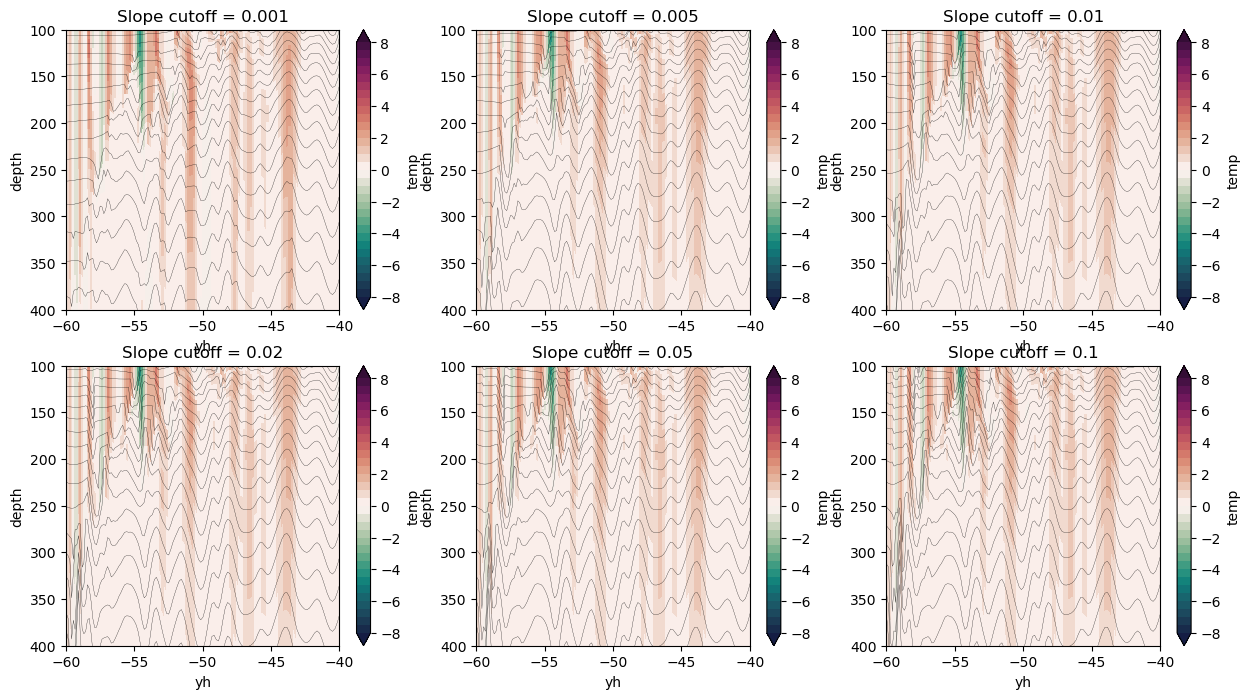

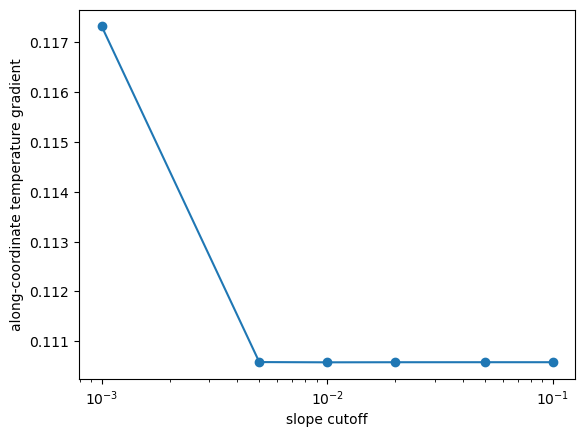

In [23]:
plt.figure(figsize=(15,8))
vlev = np.linspace(-8,8,33)
delTmean = []
jj=0
slope_cutoffs=[0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
for slope_cutoff in slope_cutoffs: 
    jj+=1
    temp_depth = xr.open_dataset('x77/anu-tub/diagnostics/OUTPUTS/vary_slope_cutoff/temp_slope_cutoff_'+str(slope_cutoff)+'.nc')
    delT = temp_depth.temp.differentiate('yh')
    depth=temp_depth.depth.values
    yh=temp_depth.yh.values
    plt.subplot(2,3,jj)
    delT.plot(y = "depth",levels=vlev,cmap=cm.cm.curl)
    for ii in range(75):
        plt.plot(yh,depth[ii,:],'k',linewidth=0.2)
    plt.ylim([100,400])
    plt.gca().invert_yaxis()
    plt.xlim([-60,-40])
    plt.title('Slope cutoff = '+str(slope_cutoff))
    
    delT1 = np.fabs(temp_depth.temp.differentiate('yh').sel(yh=slice(-50,50)).isel(zl=slice(39,70))).mean().values.item()
    delTmean.append(delT1)

plt.figure()
plt.semilogx(slope_cutoffs,delTmean,'-o')
plt.xlabel('slope cutoff')
plt.ylabel('along-coordinate temperature gradient');

This is a confusing result, because the coordinate looks slightly better behaved at very small slope cutoff, but is not sensitive to larger values. I don't really understand this one.

**Perhaps what is needed is to avoid the switching behaviour, and to implement a more gradual decline in density adaptivity?**

### Adaptivity timescale

`ADAPT_TIMESCALE = 3600.0        !   [s] default = 8.64E+04; Timescale for adaptivity diffusivity (defaults to a day)`

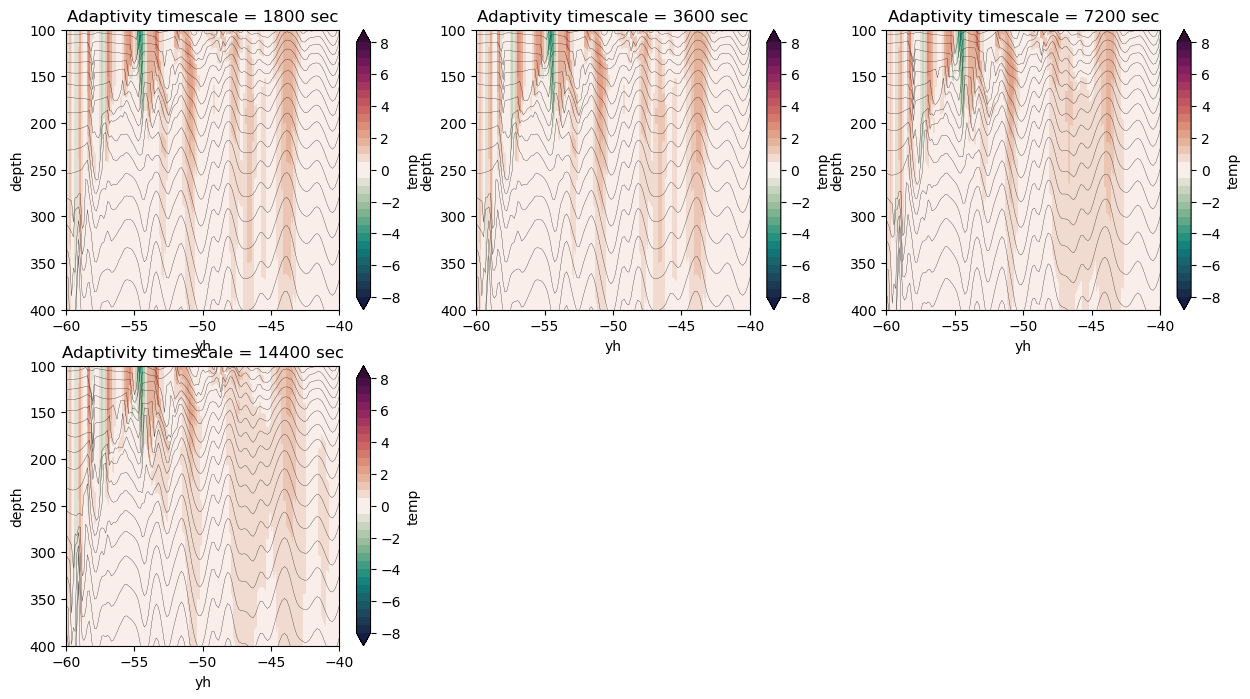

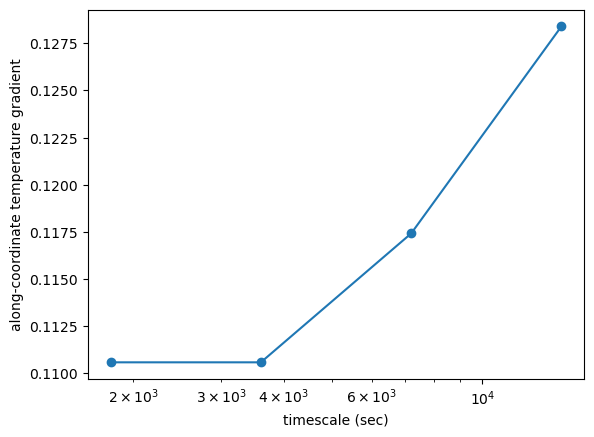

In [10]:
plt.figure(figsize=(15,8))
vlev = np.linspace(-8,8,33)
delTmean = []
jj=0
timescales=[1800, 3600, 7200, 14400]
for timescale in timescales: 
    jj+=1
    temp_depth = xr.open_dataset('x77/anu-tub/diagnostics/OUTPUTS/vary_timescale/temp_timescale_'+str(timescale)+'.nc')
    delT = temp_depth.temp.differentiate('yh')
    depth=temp_depth.depth.values
    yh=temp_depth.yh.values
    plt.subplot(2,3,jj)
    delT.plot(y = "depth",levels=vlev,cmap=cm.cm.curl)
    for ii in range(75):
        plt.plot(yh,depth[ii,:],'k',linewidth=0.2)
    plt.ylim([100,400])
    plt.gca().invert_yaxis()
    plt.xlim([-60,-40])
    plt.title('Adaptivity timescale = '+str(timescale)+' sec')
    
    delT1 = np.fabs(temp_depth.temp.differentiate('yh').sel(yh=slice(-50,50)).isel(zl=slice(39,70))).mean().values.item()
    delTmean.append(delT1)

plt.figure()
plt.semilogx(timescales,delTmean,'-o')
plt.xlabel('timescale (sec)')
plt.ylabel('along-coordinate temperature gradient');

I can't see any reason to change from the default here.

There are a few other parameters we could look at, but I don't think it's likely that these will have much of an effect:


```
ADAPT_ALPHA_RHO = -1.0          !   [nondim] default = -1.0
      ! Density adaptivity coefficient (use negative value for automatic)
ADAPT_ALPHA_P = -1.0            !   [nondim] default = -1.0
      ! Pressure adaptivity coefficient (use negative value for automatic)
ADAPT_MEAN_H = False            !   [Boolean] default = False
      ! Use mean rather than 'upstream' h in calculations
ADAPT_ADJUSTMENT_SCALE = 0.1    !   [not defined] default = 1.0
      ! Non-dimensional scale for adjusting interface positions when
      ! a diagonal convective instability would occur. When set to 1,
      ! perform the full adjustment permitted by the local CFL value.
ADAPT_TWIN_GRADIENT = True      !   [Boolean] default = True
      ! Use twin gradient approach, requiring sign of gradient above
      ! and below an interface to agree, avoiding a vertical null mode.
ADAPT_PHYSICAL_SLOPE = True     !   [Boolean] default = True
      ! Use a physical slope calculation for weighting of terms.
ADAPT_RESTORE_MEAN = False      !   [Boolean] default = False
      ! If True, restore toward a dynamically-calculated mean interface position.
      ! Otherwise, restore toward the profile given by ALE_COORDINATE_CONFIG.
```
                                

# 4. Summary

* I don't understand why we still have along-layer T gradients in the coordinate, at depth.
* I still need to play with filter depths?
* A bit more smoothing may be useful in the default case.
* Can we have a smooth transition to switch density adaptivity off?